In [1]:
import tejapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tejapi.ApiConfig.api_key = '1nn6JiPLutgvyiYdYHBf5S3TH1wZ1J'
tejapi.ApiConfig.ignoretz = True

In [2]:
#長榮 2603 籌碼 https://api.tej.com.tw/columns.html?idCode=TRAIL/TATINST1
evergreen_chip = tejapi.get('TRAIL/TATINST1',
                            coid = '2603',
                            opts = {'columns':['coid','mdate','ttl_ex','fld024']},
                            chinese_column_name = True)
evergreen_chip

,證券名稱,年月日,合計買賣超(千股),合計持股率%
None,,,,
0,2603,2020-01-02,4681,24.43
1,2603,2020-01-03,7634,24.57
2,2603,2020-01-06,-1933,24.52
3,2603,2020-01-07,-2229,24.47
4,2603,2020-01-08,-3970,24.39
...,...,...,...,...
240,2603,2020-12-25,36469,33.82
241,2603,2020-12-28,6982,33.96
242,2603,2020-12-29,-69663,32.52


In [3]:
#長榮 2603 股價 https://api.tej.com.tw/columns.html?idCode=TRAIL/TAPRCD
evergreen_price = tejapi.get('TRAIL/TAPRCD',
                            coid = '2603',
                            opts = {'columns':['mdate','open_d']},
                            chinese_column_name = True)
evergreen_price['次日開盤價'] = evergreen_price['開盤價(元)'].shift(-1)
evergreen_price

,年月日,開盤價(元),次日開盤價
None,,,
0,2020-01-02,12.60,12.80
1,2020-01-03,12.80,13.00
2,2020-01-06,13.00,13.00
3,2020-01-07,13.00,12.75
4,2020-01-08,12.75,12.75
...,...,...,...
240,2020-12-25,33.00,34.75
241,2020-12-28,34.75,39.00
242,2020-12-29,39.00,38.00


In [4]:
#市場報酬
market = tejapi.get('TRAIL/TAPRCD',
                            coid = 'Y9997',
                            opts = {'columns':['mdate', 'roi']},
                            chinese_column_name = True)
market = market.rename(columns = {'報酬率％':'市場報酬率%'})
market

,年月日,市場報酬率%
None,,
0,2020-01-02,0.8614
1,2020-01-03,0.0823
2,2020-01-06,-1.2970
3,2020-01-07,-0.6110
4,2020-01-08,-0.5322
...,...,...
240,2020-12-25,0.3581
241,2020-12-28,1.0582
242,2020-12-29,-0.0761


In [5]:
#合併
evergreen = evergreen_chip.merge(evergreen_price, on = '年月日')
evergreen = evergreen.merge(market, on = '年月日')
evergreen

,證券名稱,年月日,合計買賣超(千股),合計持股率%,開盤價(元),次日開盤價,市場報酬率%
0,2603,2020-01-02,4681,24.43,12.60,12.80,0.8614
1,2603,2020-01-03,7634,24.57,12.80,13.00,0.0823
2,2603,2020-01-06,-1933,24.52,13.00,13.00,-1.2970
3,2603,2020-01-07,-2229,24.47,13.00,12.75,-0.6110
4,2603,2020-01-08,-3970,24.39,12.75,12.75,-0.5322
...,...,...,...,...,...,...,...
240,2603,2020-12-25,36469,33.82,33.00,34.75,0.3581
241,2603,2020-12-28,6982,33.96,34.75,39.00,1.0582
242,2603,2020-12-29,-69663,32.52,39.00,38.00,-0.0761
243,2603,2020-12-30,11001,32.75,38.00,38.70,1.4901


In [6]:
#建立買賣點欄位
evergreen['合計買賣超'] = np.where(evergreen['合計買賣超(千股)'] >= 0, 1, 0)
evergreen['持股率_5日MA'] = evergreen['合計持股率%'].rolling(5).mean()
evergreen['合計持股變化'] = np.where(evergreen['合計持股率%'] - evergreen['持股率_5日MA'] > 0, 1, 0)
evergreen = evergreen.dropna().reset_index(drop=True)
evergreen

,證券名稱,年月日,合計買賣超(千股),合計持股率%,開盤價(元),次日開盤價,市場報酬率%,合計買賣超,持股率_5日MA,合計持股變化
0,2603,2020-01-08,-3970,24.39,12.75,12.75,-0.5322,0,24.476,0
1,2603,2020-01-09,1020,24.39,12.75,12.90,1.2992,1,24.468,0
2,2603,2020-01-10,12553,24.67,12.90,13.15,0.4514,1,24.488,1
3,2603,2020-01-13,1896,24.71,13.15,13.15,0.7382,1,24.526,1
4,2603,2020-01-14,6599,24.84,13.15,13.20,0.5481,1,24.600,1
...,...,...,...,...,...,...,...,...,...,...
235,2603,2020-12-24,560,33.06,31.70,33.00,0.4021,1,33.308,0
236,2603,2020-12-25,36469,33.82,33.00,34.75,0.3581,1,33.348,1
237,2603,2020-12-28,6982,33.96,34.75,39.00,1.0582,1,33.408,1
238,2603,2020-12-29,-69663,32.52,39.00,38.00,-0.0761,0,33.282,0


In [7]:
#設定訊號 
evergreen['訊號'] = np.where((evergreen['合計買賣超'] == 1)&(evergreen['合計持股變化'] == 0), 'Buy', '') #買點
evergreen['訊號'] = np.where((evergreen['合計買賣超'] == 0)&(evergreen['合計持股變化'] == 1), 'Sell', evergreen['訊號']) #賣點
evergreen['訊號'][len(evergreen)-1] = 'Sell'
evergreen

<ipython-input-7-1f072148f07d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evergreen['訊號'][len(evergreen)-1] = 'Sell'


,證券名稱,年月日,合計買賣超(千股),合計持股率%,開盤價(元),次日開盤價,市場報酬率%,合計買賣超,持股率_5日MA,合計持股變化,訊號
0,2603,2020-01-08,-3970,24.39,12.75,12.75,-0.5322,0,24.476,0,
1,2603,2020-01-09,1020,24.39,12.75,12.90,1.2992,1,24.468,0,Buy
2,2603,2020-01-10,12553,24.67,12.90,13.15,0.4514,1,24.488,1,
3,2603,2020-01-13,1896,24.71,13.15,13.15,0.7382,1,24.526,1,
4,2603,2020-01-14,6599,24.84,13.15,13.20,0.5481,1,24.600,1,
...,...,...,...,...,...,...,...,...,...,...,...
235,2603,2020-12-24,560,33.06,31.70,33.00,0.4021,1,33.308,0,Buy
236,2603,2020-12-25,36469,33.82,33.00,34.75,0.3581,1,33.348,1,
237,2603,2020-12-28,6982,33.96,34.75,39.00,1.0582,1,33.408,1,
238,2603,2020-12-29,-69663,32.52,39.00,38.00,-0.0761,0,33.282,0,


In [8]:
hold = 0
cost = 0
Return = []
for i in range(len(evergreen)):
    if evergreen['訊號'][i] == '':
        Return.append(0)
    elif evergreen['訊號'][i] == 'Buy':
        if hold == 0:
            cost = evergreen['次日開盤價'][i]
            hold = 1
            Return.append(0)
        else:
            Return.append(0)
    elif evergreen['訊號'][i] == 'Sell':
        if hold == 1:
            Return.append(100*(np.log(evergreen['次日開盤價'][i]/cost)- 0.001425*2 - 0.003))
            hold = 0
        else:
            Return.append(0)
evergreen['籌碼面報酬率(%)'] = Return
evergreen

,證券名稱,年月日,合計買賣超(千股),合計持股率%,開盤價(元),次日開盤價,市場報酬率%,合計買賣超,持股率_5日MA,合計持股變化,訊號,籌碼面報酬率(%)
0,2603,2020-01-08,-3970,24.39,12.75,12.75,-0.5322,0,24.476,0,,0.000000
1,2603,2020-01-09,1020,24.39,12.75,12.90,1.2992,1,24.468,0,Buy,0.000000
2,2603,2020-01-10,12553,24.67,12.90,13.15,0.4514,1,24.488,1,,0.000000
3,2603,2020-01-13,1896,24.71,13.15,13.15,0.7382,1,24.526,1,,0.000000
4,2603,2020-01-14,6599,24.84,13.15,13.20,0.5481,1,24.600,1,,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
235,2603,2020-12-24,560,33.06,31.70,33.00,0.4021,1,33.308,0,Buy,0.000000
236,2603,2020-12-25,36469,33.82,33.00,34.75,0.3581,1,33.348,1,,0.000000
237,2603,2020-12-28,6982,33.96,34.75,39.00,1.0582,1,33.408,1,,0.000000
238,2603,2020-12-29,-69663,32.52,39.00,38.00,-0.0761,0,33.282,0,,0.000000


In [11]:
evergreen['籌碼累積報酬率'] = evergreen['籌碼面報酬率(%)'].apply(lambda x: 0.01*x+1).cumprod()
evergreen['市場累積報酬率'] = evergreen['市場報酬率%'].apply(lambda x: 0.01*x+1).cumprod()
evergreen

,證券名稱,年月日,合計買賣超(千股),合計持股率%,開盤價(元),次日開盤價,市場報酬率%,合計買賣超,持股率_5日MA,合計持股變化,訊號,籌碼面報酬率(%),籌碼累積報酬率,市場累積報酬率
0,2603,2020-01-08,-3970,24.39,12.75,12.75,-0.5322,0,24.476,0,,0.000000,1.000000,0.994678
1,2603,2020-01-09,1020,24.39,12.75,12.90,1.2992,1,24.468,0,Buy,0.000000,1.000000,1.007601
2,2603,2020-01-10,12553,24.67,12.90,13.15,0.4514,1,24.488,1,,0.000000,1.000000,1.012149
3,2603,2020-01-13,1896,24.71,13.15,13.15,0.7382,1,24.526,1,,0.000000,1.000000,1.019621
4,2603,2020-01-14,6599,24.84,13.15,13.20,0.5481,1,24.600,1,,0.000000,1.000000,1.025209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2603,2020-12-24,560,33.06,31.70,33.00,0.4021,1,33.308,0,Buy,0.000000,1.945133,1.244314
236,2603,2020-12-25,36469,33.82,33.00,34.75,0.3581,1,33.348,1,,0.000000,1.945133,1.248770
237,2603,2020-12-28,6982,33.96,34.75,39.00,1.0582,1,33.408,1,,0.000000,1.945133,1.261985
238,2603,2020-12-29,-69663,32.52,39.00,38.00,-0.0761,0,33.282,0,,0.000000,1.945133,1.261024


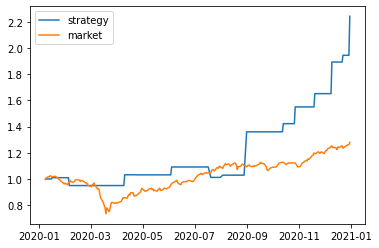

In [9]:
plt.plot(evergreen['年月日'], evergreen['籌碼累積報酬率'], label = 'strategy')
plt.plot(evergreen['年月日'], evergreen['市場累積報酬率'], label = 'market')
plt.legend()
plt.show()

In [12]:
cagr = [100*(evergreen['籌碼累積報酬率'].values[-1]**(252/len(evergreen)) - 1), 100*(evergreen['市場累積報酬率'].values[-1]**(252/len(evergreen)) - 1)]
std = [evergreen['籌碼面報酬率(%)'].std()*(252**0.5),evergreen['市場報酬率%'].std()*(252**0.5)]
sharpe_ratio = [(cagr[0] - 1)/std[0],(cagr[1] - 1)/std[1]]  #設rf = 1%
result = pd.DataFrame([cagr,std,sharpe_ratio], columns = ['籌碼面','市場'], index = ['年化報酬(%)','年化標準差(%)','夏普比率'])
result

,籌碼面,市場
年化報酬(%),133.618932,29.570016
年化標準差(%),43.667737,21.373507
夏普比率,3.037000,1.336702
